# Quantum Generative Adversarial Network (QGAN) for Time Series Data

This notebook implements a Quantum GAN using PennyLane to analyze and generate time series data from Optical Density (OD) measurements. We'll build this implementation step by step, explaining each component along the way.

## Setup and Imports


In [1]:
# Install required packages
%pip install pennylane torch torchvision pandas numpy matplotlib seaborn scipy statsmodels



[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library imports
#import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, wasserstein_distance, probplot
from scipy.special import lambertw
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import time
import numpy as np


# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PennyLane imports
import pennylane as qml

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Data Loading and Preprocessing

First, we'll load our Optical Density (OD) time series data and perform initial visualization and preprocessing steps.


Data shape (total measurements): torch.Size([778])


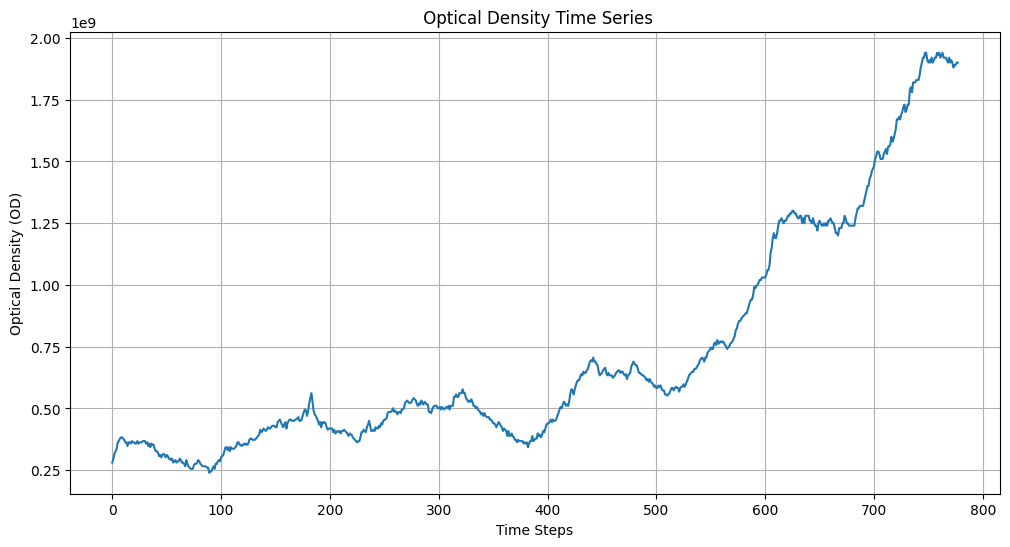


Basic data statistics:
count    7.780000e+02
mean     7.219640e+08
std      4.573705e+08
min      2.400000e+08
25%      4.090000e+08
50%      5.270000e+08
75%      8.850000e+08
max      1.940000e+09
Name: value, dtype: float64


In [3]:
# Load and preprocess the data
lucy = pd.read_csv('/Users/shawngibford/dev/Pennylane_QGAN/qGAN/lucy2.csv', header=None, names=['value'])

# Convert string values to float, replacing any non-numeric values with NaN
lucy['value'] = pd.to_numeric(lucy['value'], errors='coerce')

# Fill missing values with rolling mean
lucy['value'] = lucy['value'].fillna(lucy['value'].rolling(window=10, min_periods=10).mean())

# Drop any remaining NaN values
lucy = lucy.dropna()

# Convert to tensor
OD = torch.tensor(lucy['value'].values, dtype=torch.float32)

print('Data shape (total measurements):', OD.shape)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(OD.numpy())
plt.title(' Optical Density Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Optical Density (OD)')
plt.grid(True)
plt.show()

# Display some basic statistics
print('\nBasic data statistics:')
print(lucy['value'].describe())


## Returns Analysis

Let's calculate and visualize both direct returns and logarithmic returns of our time series.


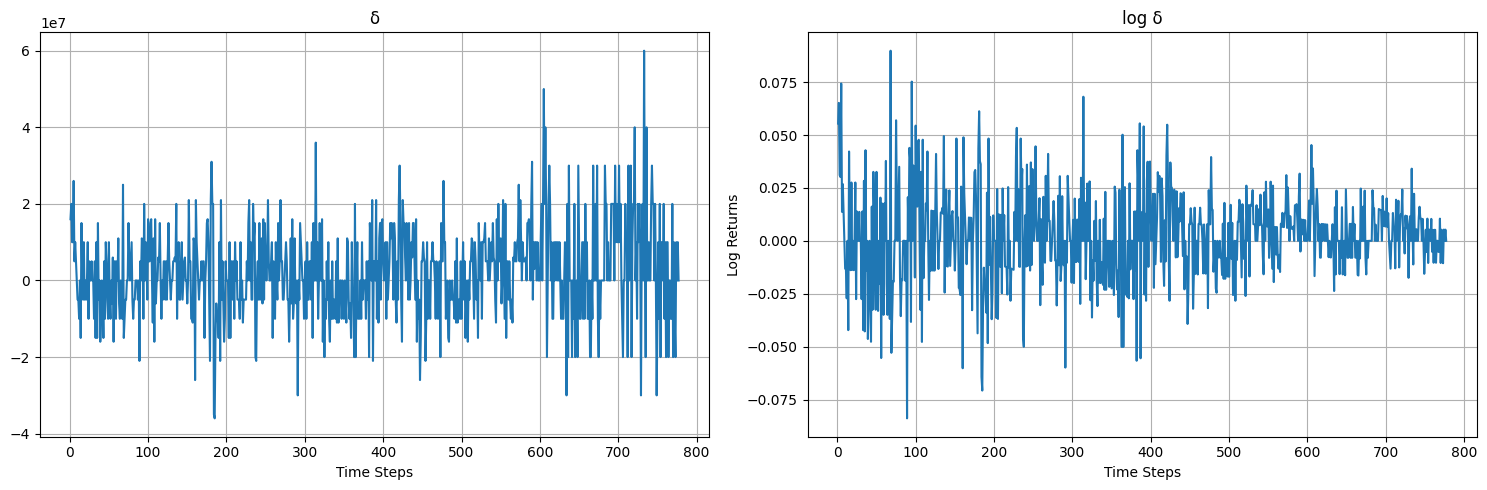


 δ Statistics:
Mean: 2083655.1250
Std: 11912895.0000
Min: -36000000.0000
Max: 60000000.0000
Skewness: 0.3014
Kurtosis: 1.0530

Log δ Statistics:
Mean: 0.0025
Std: 0.0211
Min: -0.0839
Max: 0.0898
Skewness: 0.0066
Kurtosis: 1.3363


In [4]:
# Create time index for plotting
time_index = np.arange(len(OD))

# Calculate returns
# Direct returns over time
OD_delta = OD[1:] - OD[:-1]

# Logarithmic returns over time
OD_log_delta = torch.log(OD[1:]) - torch.log(OD[:-1])

# Convert to numpy for plotting
OD_delta_np = OD_delta.numpy()
OD_log_delta_np = OD_log_delta.numpy()

# Plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot direct returns
axes[0].plot(time_index[1:], OD_delta_np)
axes[0].set_title('\u03B4')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('')
axes[0].grid(True)

# Plot log returns
axes[1].plot(time_index[1:], OD_log_delta_np)
axes[1].set_title('log \u03B4')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Log Returns')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print basic statistics of returns
print("\n \u03B4 Statistics:")
print(f"Mean: {np.mean(OD_delta_np):.4f}")
print(f"Std: {np.std(OD_delta_np):.4f}")
print(f"Min: {np.min(OD_delta_np):.4f}")
print(f"Max: {np.max(OD_delta_np):.4f}")
print(f"Skewness: {stats.skew(OD_delta_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(OD_delta_np):.4f}")

print("\nLog \u03B4 Statistics:")
print(f"Mean: {np.mean(OD_log_delta_np):.4f}")
print(f"Std: {np.std(OD_log_delta_np):.4f}")
print(f"Min: {np.min(OD_log_delta_np):.4f}")
print(f"Max: {np.max(OD_log_delta_np):.4f}")
print(f"Skewness: {stats.skew(OD_log_delta_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(OD_log_delta_np):.4f}")




In [5]:
df = pd.DataFrame(OD_log_delta)

# Save the DataFrame to a CSV file
csv_filename = 'original_OD_log_delts.csv'
df.to_csv(csv_filename, index=False)

## Data Analysis

Let's analyze the statistical properties of our data to better understand what we're working with.


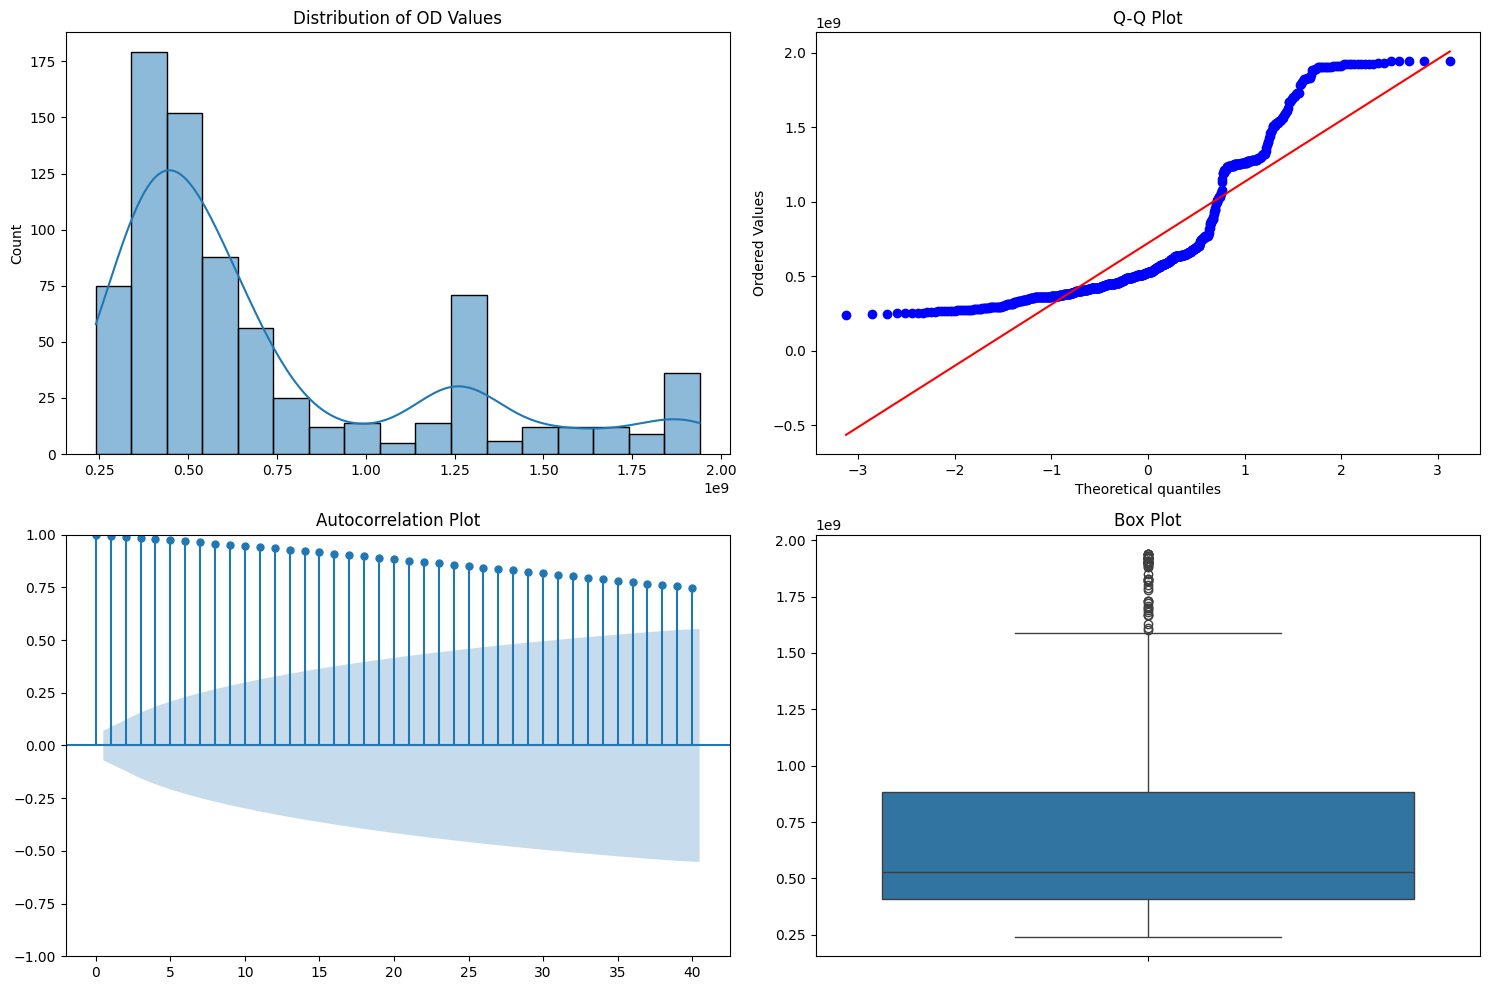


Basic Statistics:
Mean: 721964032.0000
Std: 457076448.0000
Min: 240000000.0000
Max: 1940000000.0000
Skewness: 1.3044
Kurtosis: 0.5516


In [6]:
# Statistical analysis of the data
data = OD.numpy()

# Create subplots for different visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
sns.histplot(data=data, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of OD Values')

# Q-Q plot
stats.probplot(data, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot')

# Autocorrelation plot
sm.graphics.tsa.plot_acf(data, lags=40, ax=axes[1,0])
axes[1,0].set_title('Autocorrelation Plot')

# Box plot
sns.boxplot(data=data, ax=axes[1,1])
axes[1,1].set_title('Box Plot')

plt.tight_layout()
plt.show()

# Print basic statistics
print('\nBasic Statistics:')
print(f'Mean: {np.mean(data):.4f}')
print(f'Std: {np.std(data):.4f}')
print(f'Min: {np.min(data):.4f}')
print(f'Max: {np.max(data):.4f}')
print(f'Skewness: {stats.skew(data):.4f}')
print(f'Kurtosis: {stats.kurtosis(data):.4f}')


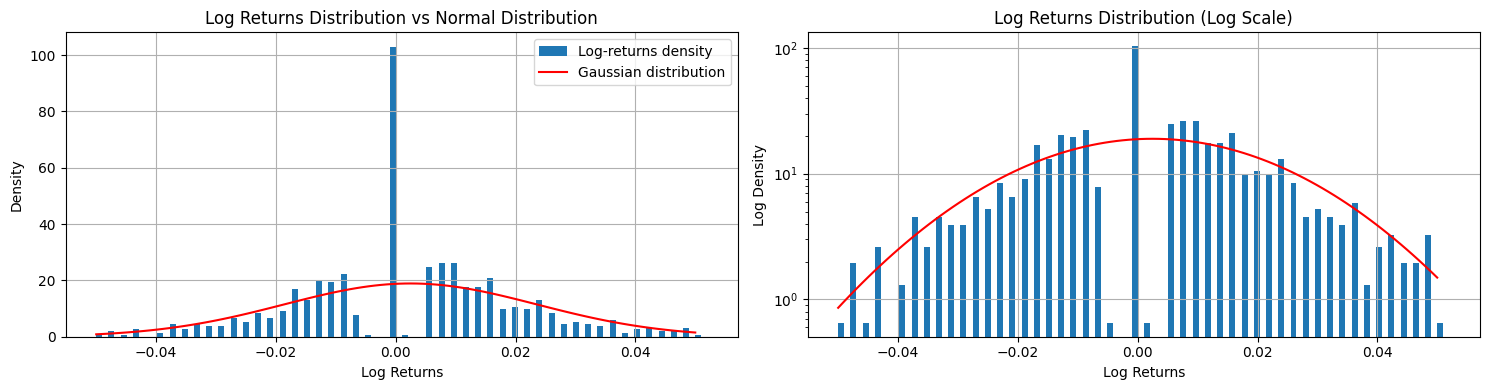


Log Returns Statistics:
Mean: 0.0025
Standard Deviation: 0.0211
Skewness: 0.0066
Kurtosis: 1.3363


In [7]:
# Analyze the distribution of log returns
# Convert PyTorch tensor to numpy array for plotting
OD_log_delta_np = OD_log_delta.numpy()
 
# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(OD_log_delta_np, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(OD_log_delta_np)
sigma = np.std(OD_log_delta_np)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()
axes[0].set_title('Log Returns Distribution vs Normal Distribution')
axes[0].set_xlabel('Log Returns')
axes[0].set_ylabel('Density')

# plot in logarithmic scale
axes[1].hist(OD_log_delta_np, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()
axes[1].set_title('Log Returns Distribution (Log Scale)')
axes[1].set_xlabel('Log Returns')
axes[1].set_ylabel('Log Density')

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')

plt.tight_layout()
plt.show()

# Print some statistics about the log returns
print("\nLog Returns Statistics:")
print(f"Mean: {mu:.4f}")
print(f"Standard Deviation: {sigma:.4f}")
print(f"Skewness: {stats.skew(OD_log_delta_np):.4f}")
print(f"Kurtosis: {stats.kurtosis(OD_log_delta_np):.4f}")


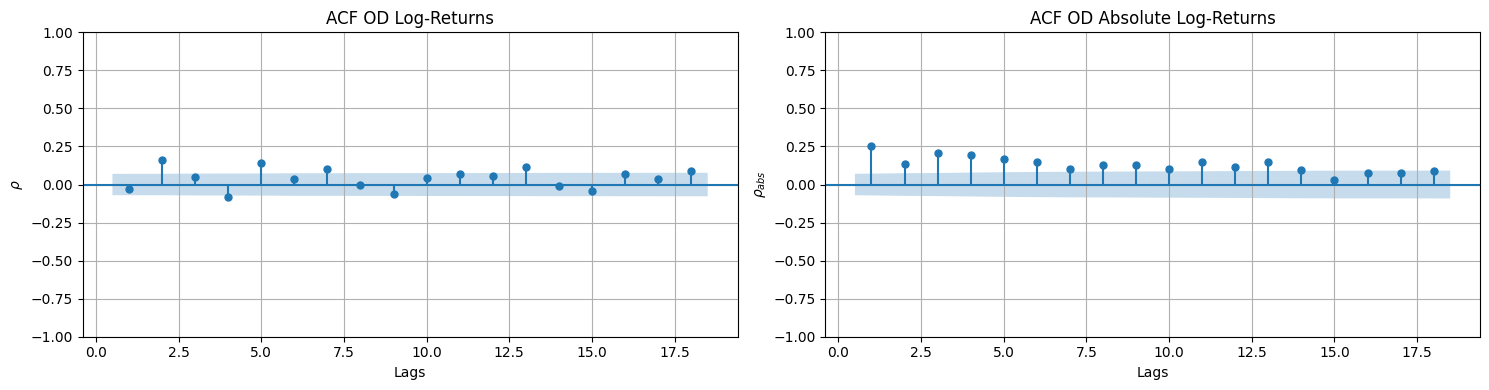


Autocorrelation Statistics:
First-order autocorrelation of log returns: -0.0300
First-order autocorrelation of absolute log returns: 0.2500


In [8]:
# Analyze autocorrelation in log returns
# Convert PyTorch tensor to numpy array for ACF plotting
OD_log_delta_np = OD_log_delta.numpy()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot ACF of log returns
tsaplots.plot_acf(OD_log_delta_np, lags=18, zero=False, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_title('ACF OD Log-Returns')
ax1.set_ylabel(r'$\rho$')
ax1.grid(True)

# Plot ACF of absolute log returns
tsaplots.plot_acf(np.abs(OD_log_delta_np), lags=18, zero=False, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_title('ACF OD Absolute Log-Returns')
ax2.set_ylabel(r'$\rho_{abs}$')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print some additional statistics about the autocorrelation
print("\nAutocorrelation Statistics:")


# Calculate first-order autocorrelation for both series
acf_log = sm.tsa.acf(OD_log_delta_np, nlags=1)[1]
acf_abs = sm.tsa.acf(np.abs(OD_log_delta_np), nlags=1)[1]
print(f"First-order autocorrelation of log returns: {acf_log:.4f}")
print(f"First-order autocorrelation of absolute log returns: {acf_abs:.4f}")


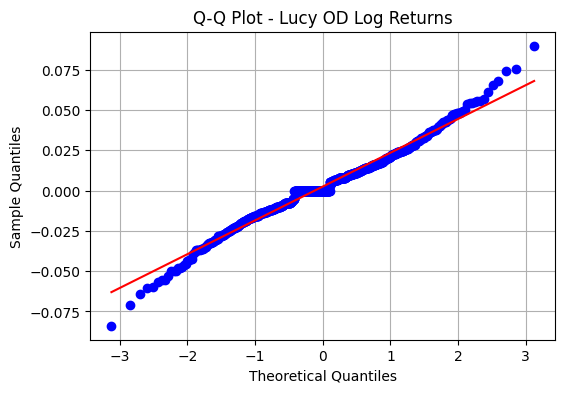

In [9]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(OD_log_delta, dist='norm', plot=plt)
plt.title('Q-Q Plot - Lucy OD Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

## Data Preprocessing Utilities

We'll define several utility functions for data preprocessing, including normalization, Lambert W transformation, and sliding window creation.


In [10]:
# Define utility functions for data preprocessing
def normalize(data):
    """Normalize the data to have zero mean and unit variance."""
    mu = torch.mean(data)
    sigma = torch.std(data)
    return (data - mu) / sigma  # Return only normalized data

def denormalize(norm_data, mu_original, std_original):
    """Denormalize the data back to original scale."""
    return norm_data * std_original + mu_original

In [11]:
# normalize the log-returns
OD_norm_d = normalize(OD_log_delta)

# display the mean and standard deviation of the original log-returns
print(f'Original Lucy OD log-returns mean = {torch.mean(OD_log_delta)}, std = {torch.std(OD_log_delta)}')

# display the mean and standard deviation of the normalized log-returns
print(f'Normalized Lucy OD log-returns mean = {torch.mean(OD_norm_d)}, std = {torch.std(OD_norm_d)}')

Original Lucy OD log-returns mean = 0.002459787530824542, std = 0.02110857143998146
Normalized Lucy OD log-returns mean = 4.909520345819374e-09, std = 1.0


Original Data Min-Max
-0.08388137817382812 0.08982658386230469
Normalized Data Min-Max
-4.090336799621582 4.138925075531006


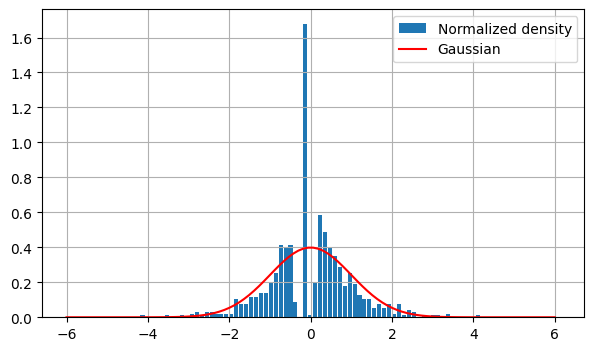

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

print('Original Data Min-Max')
print(torch.min(OD_log_delta).item(), torch.max(OD_log_delta).item())

print('Normalized Data Min-Max')
print(torch.min(OD_norm_d).item(), torch.max(OD_norm_d).item())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of log-returns
bin_edges = np.linspace(-6, 6, num=100)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

# Convert PyTorch tensor to numpy for matplotlib
axes.hist(OD_norm_d.numpy(), bins=bin_edges, density=True, width=0.1, label='Normalized density')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = torch.mean(OD_norm_d).item()  # Convert to Python scalar
sigma = torch.std(OD_norm_d).item()  # Convert to Python scalar

# Generate a set of points x
x = np.linspace(-6, 6, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

In [13]:
import torch
from scipy.special import lambertw

def inverse_lambert_w_transform(data, delta):
    """
    Apply inverse Lambert W transform to the input data using the specified delta value.

    Parameters:
    - data: Input data tensor
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Transformed data tensor
    """
    # Convert to float64 for precision
    data = data.double()
    
    sign = torch.sign(data)
    
    # Convert to numpy for lambertw, then back to tensor
    data_squared = data ** 2
    lambert_input = (delta * data_squared).cpu().numpy()
    lambert_result = lambertw(lambert_input).real
    
    # Convert back to tensor and apply transform
    lambert_tensor = torch.tensor(lambert_result, dtype=torch.float64, device=data.device)
    transformed_data = sign * torch.sqrt(lambert_tensor / delta)

    return transformed_data

def lambert_w_transform(transformed_data, delta, clip_low=-12.0, clip_high=11.0):
    """
    Transform the Gaussianized data back to its original state.

    Parameters:
    - transformed_data: Input data tensor which was transformed using inverse Lambert W
    - delta: Delta value for the transform (tail parameter)
    - clip_low: Lower clipping bound
    - clip_high: Upper clipping bound

    Returns:
    - Original Data tensor
    """
    # Convert to float64 for precision
    transformed_data = transformed_data.double()
    
    # Apply the reverse transform
    exp_term = torch.exp((delta / 2) * transformed_data ** 2)
    reversed_data = transformed_data * exp_term
    
    # Clip the values
    return torch.clamp(reversed_data, clip_low, clip_high)

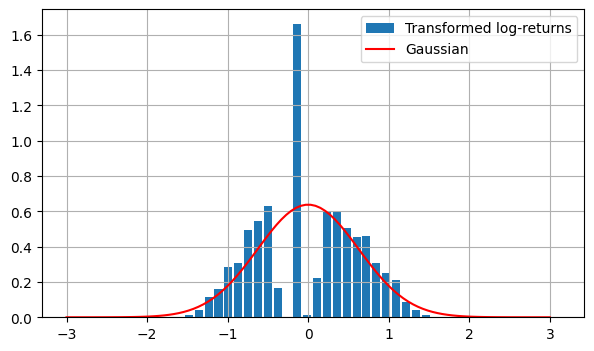

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# apply inverse Lambert W transform to the normalized log-returns
delta = 1
transformed_OD_norm_log_d = inverse_lambert_w_transform(OD_norm_d, delta)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of normalized log-returns
bin_edges = np.linspace(-3, 3, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)

# Convert PyTorch tensor to numpy for matplotlib
axes.hist(transformed_OD_norm_log_d.numpy(), bins=bin_edges, density=True, width=0.1, label='Transformed log-returns')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = torch.mean(transformed_OD_norm_log_d).item()  # Convert to Python scalar
sigma = torch.std(transformed_OD_norm_log_d).item()  # Convert to Python scalar

# Generate a set of points x
x = np.linspace(-3, 3, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the normalized log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

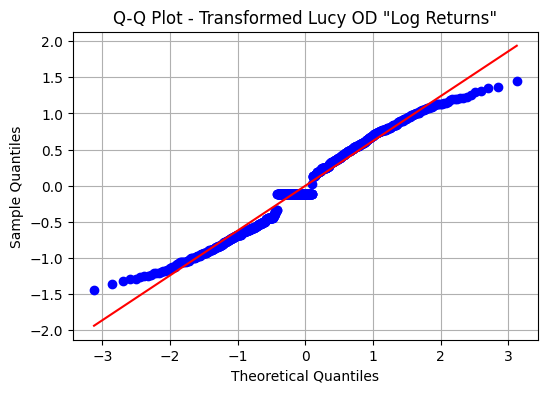

In [15]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(transformed_OD_norm_log_d, dist='norm', plot=plt)
plt.title('Q-Q Plot - Transformed Lucy OD "Log Returns"')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [16]:
print('Transformed Data Min-Max')
print(torch.min(transformed_OD_norm_log_d).item(), torch.max(transformed_OD_norm_log_d).item())

Transformed Data Min-Max
-1.4433644659128437 1.4488887136715398


In [17]:
min_val = torch.min(transformed_OD_norm_log_d)
max_val = torch.max(transformed_OD_norm_log_d)
scaled_data = -1.0 + 2.0 * (transformed_OD_norm_log_d - min_val) / (max_val - min_val)

In [18]:
print(f'Scaled Normalized Transformed log-returns mean = {torch.mean(scaled_data)}, std = {torch.std(scaled_data)}')
print('Scaled Normalized Transformed log-returns min-max: ', torch.min(scaled_data).item(), torch.max(scaled_data).item())

Scaled Normalized Transformed log-returns mean = -0.0016953676447610307, std = 0.4325888095928082
Scaled Normalized Transformed log-returns min-max:  -1.0 1.0


In [19]:
import torch

def rescale(scaled_data, original_data):
    """
    Scale back from [-1,1] to the previous range
    
    Parameters:
    - scaled_data: Data scaled to [-1, 1] range
    - original_data: Original data to get min/max values from
    
    Returns:
    - Rescaled data in original range
    """
    min_val = torch.min(original_data)
    max_val = torch.max(original_data)
    previous_data = 0.5 * (scaled_data + 1.0) * (max_val - min_val) + min_val
    
    return previous_data

def rolling_window(data, m, s):
    """
    Create rolling windows from data
    
    Parameters:
    - data: Input tensor
    - m: Window size
    - s: Step size (stride)
    
    Returns:
    - Tensor of rolling windows
    """
    # Calculate number of windows
    num_windows = (len(data) - m) // s + 1
    
    # Create indices for each window
    windows = []
    for i in range(0, len(data) - m + 1, s):
        windows.append(data[i:i+m])
    
    # Stack all windows into a tensor
    return torch.stack(windows)

In [20]:
# Enable best available device (CUDA > MPS > CPU)
device = torch.device(
            "cuda:0" if torch.cuda.is_available() 
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
        )

In [21]:
class qGAN(nn.Module):
    def __init__(self, num_epochs, batch_size, window_length, n_critic, gp, num_layers, num_qubits):
        super().__init__()  # Modern Python 3+ syntax
        
        # classical hyperparameters
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.window_length = window_length
        self.n_critic = n_critic
        self.gp = gp
        
        # quantum hyperparameters
        self.num_layers = num_layers
        self.num_qubits = num_qubits 

        # Quantum device (for PennyLane)
        self.quantum_dev = qml.device("default.qubit", wires=self.num_qubits)
        
        # PyTorch device (for classical computation)
        self.torch_device = torch.device(
            "cuda:0" if torch.cuda.is_available() 
            else "mps" if torch.backends.mps.is_available() 
            else "cpu"
        )
        
        # quantum circuit settings
        self.qubits = list(range(num_qubits))  # PennyLane uses wire indices instead of GridQubit
        
        # create the set of Pauli strings to measure -> {X1, Z1, X2, Z2, etc}
        # X1 means we measure the first qubit only with X, Z1 the first qubit only with Z and so on...
        # Return measurements based on self.measurements (X and Z measurements)
        self.measurements = []
        for i in range(self.num_qubits):
            self.measurements.append(qml.expval(qml.PauliX(i)))  # X measurement
            self.measurements.append(qml.expval(qml.PauliZ(i)))  # Z measurement


        # number of parameters of the PQC and re-uploading layers
        self.num_params = self.count_params()

        # define the trainable parameters of the PQC main and re-uploading layers (trainable)
        self.params_pqc = torch.nn.Parameter(torch.randn(self.num_params, requires_grad=True))  # PyTorch parameters instead of sympy symbols

        # define the classical critic network (CNN)
        self.critic = self.define_critic_model(window_length)
        # define the quantum generator network (PQC)
        self.generator = self.define_generator_model()

        # Create QNode with proper PyTorch integration for gradient flow        
        # # Use parameter-shift as fallback for better stability with quantum parameters
        #self.generator_circuit = qml.QNode(self.define_generator_circuit, self.quantum_dev, 
                        #interface='torch', diff_method='best')

        # monitoring purposes
        # average critic and generator losses for each epoch
        self.critic_loss_avg = []
        self.generator_loss_avg = []

        # Earth's mover distance (EMD) for each epoch
        self.emd_avg = []

        # stylized facts RMSEs for each epoch
        self.acf_avg = []
        self.vol_avg = []
        self.lev_avg = []

# Part 2
    ####################################################################################
    #
    # count the parameters of the quantum circuit
    #
    ####################################################################################
    def count_params(self):

        # rotation layer with Rx, Ry, Rz has 3N parameters, where N is the number of qubits
        # the entangling layer is not parameterized
        num_params_pqc = 3*self.num_qubits*self.num_layers

        # also, count the parameters of the re-uploading layer that is sandwiched between rotation-entangling layers
        # there is one re-uploading layer after each rotation-entangling layer with a parameterized Rx gate,
        # so the number of parameters is equal to the number of qubits for each re-uploading layer
        num_params_upload = self.num_layers*self.num_qubits

        # the last layer of the PQC is a rotation layer
        num_params_pqc += 3*self.num_qubits

        return num_params_pqc+num_params_upload

    ####################################################################################
    #
    # the classical critic model as a convolutional network
    #
    ####################################################################################
    def define_critic_model(self, window_length):
        """Define the classical critic model"""
        model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=64, kernel_size=10, stride=1, padding=5),
        nn.LeakyReLU(negative_slope=0.1),
        
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=10, stride=1, padding=5),
        nn.LeakyReLU(negative_slope=0.1),
        
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=10, stride=1, padding=5),
        nn.LeakyReLU(negative_slope=0.1),
        
        # Add adaptive pooling to get fixed size
        nn.AdaptiveAvgPool1d(output_size=1),  # This gives 128 * 1 = 128 features
        nn.Flatten(),
        
        nn.Linear(in_features=128, out_features=32),  # 128 -> 32
        nn.LeakyReLU(negative_slope=0.1),
        nn.Dropout(p=0.2),
        
        nn.Linear(in_features=32, out_features=1)
        )
    
        model = model.double()
        return model

    ####################################################################################
    #
    # the encoding layer: resolve the parameters by uniform noise values,
    # used to prepare the initial state for the generator circuit
    #
    ####################################################################################
    def encoding_layer(self, noise_params):
        """Helper function to apply encoding - used within qnode"""
        for i in range(self.num_qubits):
            qml.RX(phi=noise_params[i], wires=i)
    ####################################################################################
    #
    # the quantum generator as a PQC with All-to-all topology for the entangling layer
    #
    ####################################################################################
    def define_generator_circuit(self, noise_params, params_pqc):
        # Apply encoding layer
        self.encoding_layer(noise_params)
    
        # index for the parameter tensor of the PQC main and re-uploading layers
        idx = 0
    
        # Initial Hadamard gates
        for qubit in range(self.num_qubits):
            qml.Hadamard(wires=qubit)
    
        for layer in range(self.num_layers):
            ###############################################################
            #
            # single-qubit rotation layer
            #
            ###############################################################
            for qubit in range(self.num_qubits):
                qml.RX(phi=params_pqc[idx], wires=qubit)
                idx += 1
                qml.RY(phi=params_pqc[idx], wires=qubit)
                idx += 1
                #qml.RZ(phi=params_pqc[idx], wires=qubit)
                #idx += 1

            ###############################################################
            #
            # entangling layer (not parameterized)
            #
            ###############################################################
            for qubit1 in range(self.num_qubits):
                for qubit2 in range(qubit1+1, self.num_qubits):
                    qml.CNOT(wires=[qubit1, qubit2])

            ###############################################################
            #
            # re-uploading layer with Rx rotation
            #
            ###############################################################
            for qubit in range(self.num_qubits):
                qml.RX(phi=params_pqc[idx], wires=qubit)
                idx += 1

        #####################################################################
        #
        # single-qubit rotation layer as the last layer before measurement
        #
        #####################################################################
        for qubit in range(self.num_qubits):
            qml.RX(phi=params_pqc[idx], wires=qubit)
            idx += 1
            qml.RY(phi=params_pqc[idx], wires=qubit)
            idx += 1
            #qml.RZ(phi=params_pqc[idx], wires=qubit)
            #idx += 1
    
        measurements = []
        for i in range(self.num_qubits):
            measurements.append(qml.expval(qml.PauliX(i)))  # X measurement
            measurements.append(qml.expval(qml.PauliZ(i)))  # Z measurement
    
        return measurements

    ####################################################################################
    #
    # the quantum generator model
    #
    ####################################################################################
    def define_generator_model(self):
        # model input (equivalent to tf.keras.Input)
        # In PennyLane/PyTorch, we don't need explicit input definition like TensorFlow
        q_data_input = None  # Placeholder to match structure
    
        # define the pennylane quantum layer (trainable)
        generator = qml.QNode(self.define_generator_circuit, self.quantum_dev, interface='torch', diff_method='best')
    
        # generator output (will be computed when called)
        generator_output = generator
    
        # pytorch model equivalent
        model = generator
    
        return model    


    #############################################################################
    #
    # compile model with given optimizers for critic and generator networks
    #
    #############################################################################
    def compile_QGAN(self, c_optimizer, g_optimizer):
        # PyTorch doesn't have a compile method like Keras
        # Just store the optimizers
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def train_qgan(self, gan_data, original_data, preprocessed_data, num_elements):
        """
        Parameters:
        - gan_data is the preprocessed dataset with windows for qGAN training
        - original_data is the original S&P 500 log-returns for evaluation of RMSEs (monitoring purposes)
        - preprocessed_data is the preprocessed log-returns without the last normalization step and without windows
         (for reversing the process of generated samples using the mean and std and evaluating the RMSEs)
        """
        # Convert DataLoader to list for random sampling (PyTorch approach)
        gan_data_list = []
        for batch in gan_data:
            for sample in batch[0]:  # batch[0] contains the data
                gan_data_list.append(sample)

        # training loop
        for epoch in range(self.num_epochs):
            print(f'Processing epoch {epoch+1}/{self.num_epochs}')
        ################################################################
        #
        # Train the critic for n_critic iterations
        # Process 'batch_size' samples in each iteration
        #
        ################################################################
        # critic loss for 'n_critic' iterations
        critic_t_sum = 0
        for t in range(self.n_critic):
            # zero gradients
            self.c_optimizer.zero_grad()
            
            # critic loss for 'batch_size' samples
            critic_sum = 0
            for i in range(self.batch_size):
                ###########################################
                #
                # Sample real data and a latent variable
                #
                ###########################################
                # PyTorch random sampling approach
                random_idx = torch.randint(0, len(gan_data_list), (1,))
                real_sample = gan_data_list[random_idx.item()]
                # reshape the real sample for compatibility with the first layer of the critic
                real_sample = torch.reshape(real_sample, (1, self.window_length))

                ##################################################
                #
                # Get the state prepared by the encoding circuit
                #
                ##################################################
                # generate noise parameters for the encoding layer
                noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
                # convert to torch tensor for quantum circuit
                generator_input = torch.tensor(noise_values, dtype=torch.float32)
                # get the fake sample as the expectations of the quantum circuit
                generated_sample = self.generator(generator_input, self.params_pqc)
                # Convert list to tensor and ensure proper dtype
                generated_sample = torch.tensor(generated_sample, dtype=torch.float64)

                # Reshape real sample and add channel dimension for Conv1D
                real_sample = torch.reshape(real_sample, (1, self.window_length))
                real_sample = real_sample.unsqueeze(1)  # Add channel dimension: [1, 1, window_length]
                real_sample = real_sample.double()

                # Reshape generated sample and add channel dimension
                generated_sample_input = generated_sample.unsqueeze(0).unsqueeze(1)  # [1, 1, window_length]

                # calculate the critic scores for real and fake samples
                real_score = self.critic(real_sample)
                fake_score = self.critic(generated_sample_input)                                
                                                                
                # compute the gradient penalty
                gradient_penalty = self.compute_gradient_penalty(real_sample, generated_sample.unsqueeze(0))

                # calculate the Wasserstein distance loss with gradient penalty
                critic_loss = fake_score - real_score + self.gp * gradient_penalty
                # accumulate the critic loss for the sample
                critic_sum += critic_loss

            # compute the gradients of critic and apply them
            (critic_sum/self.batch_size).backward()
            self.c_optimizer.step()

            # accumulate the average critic loss for all samples in this 't' iteration
            critic_t_sum += critic_sum/self.batch_size

        # average critic loss for this epoch of WGAN training
        self.critic_loss_avg.append(critic_t_sum/self.n_critic)

        ################################################################
        #
        # Train generator for one iteration
        #
        ################################################################
        # sample a batch of input states using noise parameters (not encoding layer)
        input_circuits_batch = []
        for _ in range(self.batch_size):
            noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
            input_circuits_batch.append(noise_values)  # Store the noise values, not encoding layer result

        # convert to torch tensor batch
        generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])

        # zero gradients
        self.g_optimizer.zero_grad()

        # generate fake samples using the generator
        generated_samples = []
        for generator_input in generator_inputs:
            generated_sample = self.generator(generator_input, self.params_pqc)
            generated_samples.append(torch.tensor(generated_sample, dtype=torch.float64))
        generated_samples = torch.stack(generated_samples)

        # Add channel dimension for Conv1D
        generated_samples_input = generated_samples.unsqueeze(1)  # [batch, 1, features]

        # calculate the critic scores for fake samples
        fake_scores = self.critic(generated_samples_input)

        # calculate the generator loss
        generator_loss = -torch.mean(fake_scores)

        # compute the gradients of generator and apply them
        generator_loss.backward()
        self.g_optimizer.step()

        # average generator loss for this epoch
        self.generator_loss_avg.append(generator_loss)

        ########################################################################################################
        #
        # Calculate the stylized facts RMSEs and the EMD for real and fake data
        #
        # Fake data has shape (num_samples x window_length), with num_samples = original_length / window_length
        # in order to get a time series close to the length of the original
        #
        ########################################################################################################
        # generate noise
        num_samples = len(original_data) // self.window_length
        input_circuits_batch = []
        for _ in range(num_samples):
            noise_values = np.random.uniform(0, 2 * np.pi, size=self.num_qubits)
            input_circuits_batch.append(noise_values)  # Store noise values, not encoding layer result

        # convert to torch tensor batch
        generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])

        # generate fake samples using the generator
        batch_generated = []
        for generator_input in generator_inputs:
            generated_sample = self.generator(generator_input, self.params_pqc)
            batch_generated.append(torch.tensor(generated_sample, dtype=torch.float64))
        batch_generated = torch.stack(batch_generated)

        # concatenate all time series data into one
        generated_data = torch.reshape(batch_generated, shape=(num_samples*self.window_length,))
        generated_data = generated_data.double()
        # rescale
        generated_data = rescale(generated_data, preprocessed_data)
        # reverse the preprocessing on generated sample
        original_norm = lambert_w_transform(generated_data, delta)
        fake_original = denormalize(original_norm, torch.mean(original_data), torch.std(original_data))
        
        # calculate the temporal metrics for monitoring the training process
        corr_rmse, volatility_rmse, lev_rmse, emd = self.stylized_facts(original_data, fake_original)
        # store the EMD and RMSEs of stylized facts
        self.acf_avg.append(corr_rmse)
        self.vol_avg.append(volatility_rmse)
        self.lev_avg.append(lev_rmse)
        self.emd_avg.append(emd)

        # print progress every 100 epochs
        if epoch % 100 == 0 or epoch+1 == 3000:
            print(f'\nEpoch {epoch+1} completed')
    
        # Safe access to loss values with bounds checking
        if len(self.critic_loss_avg) > epoch:
            critic_loss_val = self.critic_loss_avg[epoch]
            if hasattr(critic_loss_val, 'item'):
                critic_loss_val = critic_loss_val.item()
            print(f'Critic loss (average): {critic_loss_val}')
        else:
            print(f'Critic loss (average): Not available (index {epoch}, list length {len(self.critic_loss_avg)})')
    
        if len(self.generator_loss_avg) > epoch:
            generator_loss_val = self.generator_loss_avg[epoch]
            if hasattr(generator_loss_val, 'item'):
                generator_loss_val = generator_loss_val.item()
            print(f'Generator loss (average): {generator_loss_val}')
        else:
            print(f'Generator loss (average): Not available (index {epoch}, list length {len(self.generator_loss_avg)})')
    
        # Safe access to other metrics
        if len(self.emd_avg) > epoch:
            print(f'\nEMD (average): {self.emd_avg[epoch]}')
            print(f'ACF RMSE (average): {self.acf_avg[epoch]}')
            print(f'VOLATILITY RMSE (average): {self.vol_avg[epoch]}')
            print(f'LEVERAGE RMSE (average): {self.lev_avg[epoch]}\n')
        else:
            print(f'\nMetrics not available for epoch {epoch}')
    
        # Only print min/max if variables exist
        try:
            print('Min-Max values of original log-returns: ', torch.min(original_data).item(), torch.max(original_data).item())
            print('Min-Max values of generated log-returns (for all batches): ', torch.min(fake_original).item(), torch.max(fake_original).item())
            print('Min-Max values after Lambert: ', torch.min(original_norm).item(), torch.max(original_norm).item())
        except NameError:
            print('Min-Max values not available (variables not defined)')
            print()


    ###########################################################
    #
    # Sample a random number epsilon ~ U[0,1]
    # Create a convex combination of real and generated sample
    # Compute the gradient penalty for the critic network
    #
    ###########################################################
    def compute_gradient_penalty(self, real_sample, generated_sample):
        epsilon = torch.rand(1, dtype=torch.float64)
        interpolated_sample = epsilon * real_sample + (1 - epsilon) * generated_sample
        interpolated_sample.requires_grad_(True)

        scores = self.critic(interpolated_sample)

        gradients = torch.autograd.grad(
            outputs=scores,
            inputs=interpolated_sample,
            grad_outputs=torch.ones_like(scores),
            create_graph=True,
            retain_graph=True
        )[0]
    
        gradients_norm = torch.norm(gradients)
        gradient_penalty = (gradients_norm - 1)**2

        return gradient_penalty

    def stylized_facts(self, original_data, fake_original):
        """
        - Calculate the RMSEs of the stylized facts between the original S&P 500 log-returns and
          generated time series

        - Evaluate the EMD between real and generated samples
        """

        ################################################
        #
        # stylized facts for fake samples
        #
        ################################################
        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(fake_original, nlags=18)
        # exclude zero lag
        acf_values_generated = torch.tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(torch.abs(fake_original), nlags=18)
        # exclude zero lag
        acf_abs_values_generated = torch.tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = fake_original[:-lag]
            squared_lag_r = torch.square(torch.abs(fake_original[lag:]))

            # calculate the leverage effect
            # calculate the correlation coefficient
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])

        leverage_generated = torch.tensor(lev)

        ################################################
        #
        # stylized facts for real samples
        #
        ################################################

        # compute acf for maximum lags = 18
        acf_values = sm.tsa.acf(original_data, nlags=18)
        # exclude zero lag
        acf_values_original = torch.tensor(acf_values[1:])

        # compute absolute acf (volatility clustering) for maximum lags = 18
        acf_abs_values = sm.tsa.acf(torch.abs(original_data), nlags=18)
        # exclude zero lag
        acf_abs_values_original = torch.tensor(acf_abs_values[1:])

        # compute leverage effect for maximum lags = 18
        lev = []
        for lag in range(1, 19):
            # slice the tensors to get the appropriate lagged sequences
            r_t = original_data[:-lag]
            squared_lag_r = torch.square(torch.abs(original_data[lag:]))

            # calculate the leverage effect
            correlation_matrix = np.corrcoef(r_t, squared_lag_r)
            lev.append(correlation_matrix[0, 1])

        leverage_original = torch.tensor(lev)

        # calculate average RMSEs of stylized facts
        # autocorrelations
        rmse_acf = torch.sqrt(torch.mean((acf_values_original-acf_values_generated)**2))
        # volatility clustering
        rmse_vol = torch.sqrt(torch.mean((acf_abs_values_original-acf_abs_values_generated)**2))
        # leverage effect
        rmse_lev = torch.sqrt(torch.mean((leverage_original-leverage_generated)**2))

        ####################################################################################
        #
        # compute the Earth's mover distance (EMD)
        #
        ####################################################################################
        bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
        bin_width = bin_edges[1] - bin_edges[0]
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        # compute the empirical distribution of original data
        empirical_real, _ = np.histogram(original_data, bins=bin_edges, density=True)
        empirical_real /= np.sum(empirical_real)
        # compute the empirical distribution of generated data
        empirical_fake, _ = np.histogram(fake_original, bins=bin_edges, density=True)
        empirical_fake /= np.sum(empirical_fake)

        # evaluate the EMD using SciPy
        emd = wasserstein_distance(empirical_real, empirical_fake)

        return rmse_acf, rmse_vol, rmse_lev, emd

In [22]:
##################################################################
#
# Hyperparameters
#
##################################################################
WINDOW_LENGTH = 10  # this must be equal to the number of Pauli strings to measure
NUM_QUBITS = 5  # number of qubits
NUM_LAYERS = 3 # number of layers for the PQC

# training hyperparameters
EPOCHS = 201#2001
BATCH_SIZE = 20

n_critic = 2 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the QGAN model object
qgan = qGAN(EPOCHS, BATCH_SIZE, WINDOW_LENGTH, n_critic, LAMBDA, NUM_LAYERS, NUM_QUBITS)

# set the optimizers
c_optimizer = torch.optim.Adam(qgan.critic.parameters())
g_optimizer = torch.optim.Adam([qgan.params_pqc])  # Use the quantum parameters
qgan.compile_QGAN(c_optimizer, g_optimizer)

##################################################################################
#
# Data pre-processing
#
##################################################################################
# apply rolling window in transformed (scaled) log-returns with stride s=2
gan_data_tf = rolling_window(scaled_data, WINDOW_LENGTH, 2)
# create PyTorch datasets
gan_data = torch.utils.data.TensorDataset(torch.tensor(gan_data_tf, dtype=torch.float32))
gan_data = torch.utils.data.DataLoader(gan_data, batch_size=1, shuffle=True)
# get the number of elements in the dataset
num_elements = len(gan_data_tf)

/var/folders/x9/05_lgckd2f5fjpll2k2x6pkh0000gn/T/ipykernel_90034/3068408661.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gan_data = torch.utils.data.TensorDataset(torch.tensor(gan_data_tf, dtype=torch.float32))


/var/folders/x9/05_lgckd2f5fjpll2k2x6pkh0000gn/T/ipykernel_90034/152142667.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Circuit visualization:
0: ──RX(0.50)──H──RX(0.10)──RY(0.10)─╭●─╭●─╭●─╭●──RX(0.10)──RX(0.10)──RY(0.10)────────────────────
1: ──RX(0.50)──H──RX(0.10)──RY(0.10)─╰X─│──│──│──╭●────────╭●────────╭●─────────RX(0.10)──RX(0.10)
2: ──RX(0.50)──H──RX(0.10)──RY(0.10)────╰X─│──│──╰X────────│─────────│─────────╭●────────╭●───────
3: ──RX(0.50)──H──RX(0.10)──RY(0.10)───────╰X─│────────────╰X────────│─────────╰X────────│────────
4: ──RX(0.50)──H──RX(0.10)──RY(0.10)──────────╰X─────────────────────╰X──────────────────╰X───────

────────────╭●──────────────────╭●────────╭●─╭●──RX(0.10)──RX(0.10)──RY(0.10)────────────────────
───RY(0.10)─╰X──────────────────│─────────│──│──╭●────────╭●────────╭●─────────RX(0.10)──RX(0.10)
───RX(0.10)──RX(0.10)──RY(0.10)─╰X────────│──│──╰X────────│─────────│─────────╭●────────╭●───────
──╭●─────────RX(0.10)──RX(0.10)──RY(0.10)─╰X─│────────────╰X────────│─────────╰X────────│────────
──╰X─────────RX(0.10)──RX(0.10)──RY(0.10)────╰X─────────────────────╰X──────────────────╰

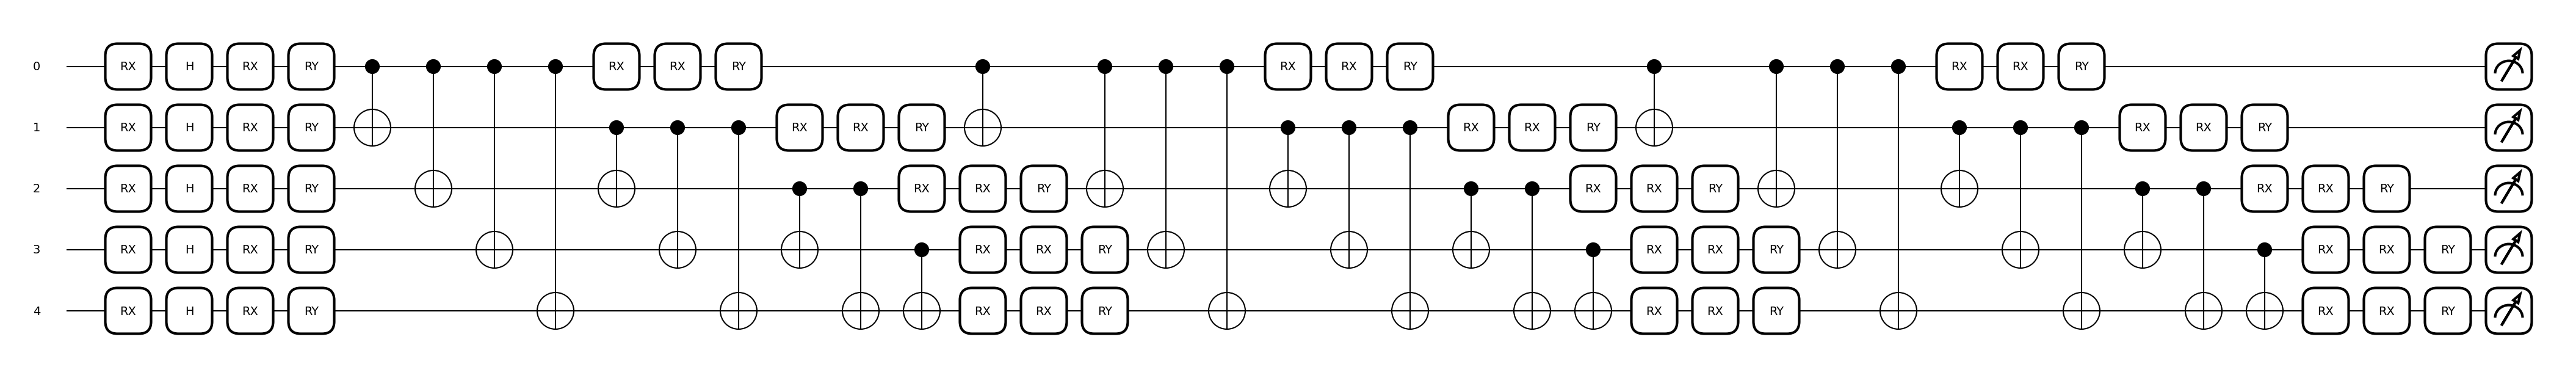

In [23]:
# Create dummy parameters for visualization
dummy_noise_params = torch.tensor([0.5] * NUM_QUBITS, dtype=torch.float32)
dummy_circuit_params = torch.tensor([0.1] * qgan.num_params, dtype=torch.float32)

# Use the correct attribute name - qgan.generator instead of qgan.qnode
print("Circuit visualization:")
print(qml.draw(qgan.generator)(dummy_noise_params, dummy_circuit_params))

# For matplotlib visualization:
fig, ax = qml.draw_mpl(qgan.generator)(dummy_noise_params, dummy_circuit_params)
fig.show()

In [24]:
# train the QGAN
print('Training started...')
print('Number of samples to process per epoch: ', num_elements)
print()
start_time_train = time.time()
model = qgan.train_qgan(gan_data, OD_log_delta, transformed_OD_norm_log_d, num_elements)
exec_time_train = time.time() - start_time_train
print(f'\nQGAN training completed. Training time: --- {exec_time_train/3600:.02f} hours ---')

Training started...
Number of samples to process per epoch:  384

Processing epoch 1/201
Processing epoch 2/201
Processing epoch 3/201
Processing epoch 4/201
Processing epoch 5/201
Processing epoch 6/201
Processing epoch 7/201
Processing epoch 8/201
Processing epoch 9/201
Processing epoch 10/201
Processing epoch 11/201
Processing epoch 12/201
Processing epoch 13/201
Processing epoch 14/201
Processing epoch 15/201
Processing epoch 16/201
Processing epoch 17/201
Processing epoch 18/201
Processing epoch 19/201
Processing epoch 20/201
Processing epoch 21/201
Processing epoch 22/201
Processing epoch 23/201
Processing epoch 24/201
Processing epoch 25/201
Processing epoch 26/201
Processing epoch 27/201
Processing epoch 28/201
Processing epoch 29/201
Processing epoch 30/201
Processing epoch 31/201
Processing epoch 32/201
Processing epoch 33/201
Processing epoch 34/201
Processing epoch 35/201
Processing epoch 36/201
Processing epoch 37/201
Processing epoch 38/201
Processing epoch 39/201
Process

Converted data shapes:
critic_loss: (1,), values: [9.75876194]
generator_loss: (1,), values: [0.04445255]
This suggests training stopped early or only ran for a few epochs.
Cannot create moving average with only 1 data point.


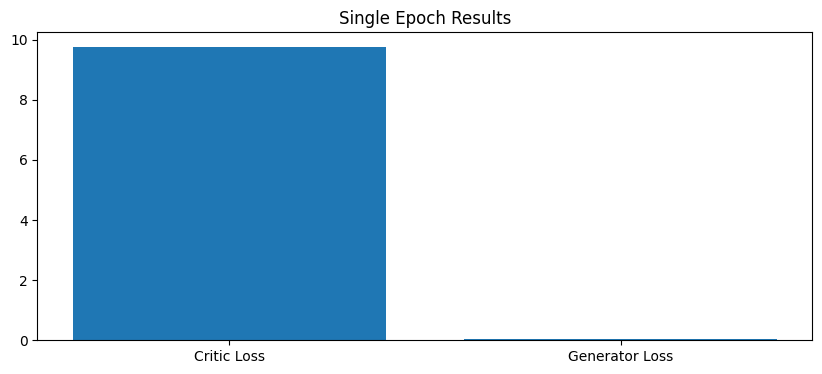

ValueError: x and y must have same first dimension, but have shapes (0,) and (50,)

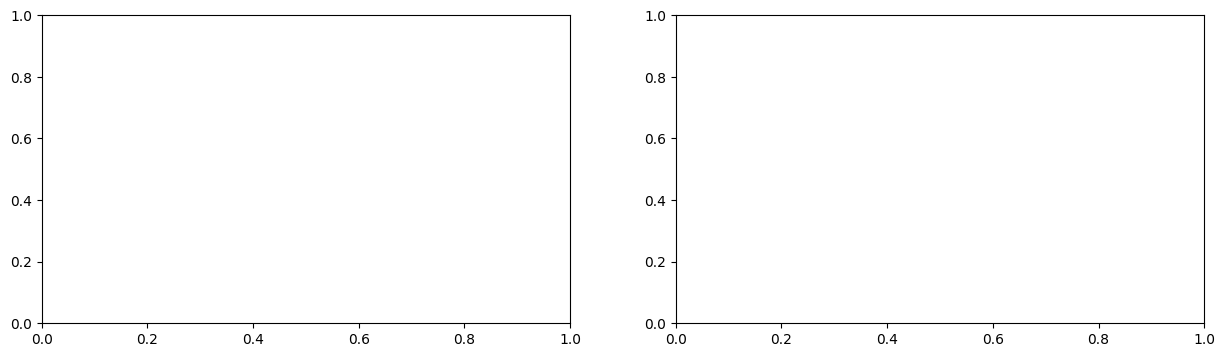

: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert PyTorch data to match TensorFlow structure exactly
def convert_losses_pytorch_to_tf_format(critic_losses, generator_losses):
    """Convert PyTorch losses to match TensorFlow format"""
    
    # Handle critic losses - equivalent to tf.squeeze(qgan.critic_loss_avg, axis=(1,2)).numpy()
    if isinstance(critic_losses, list):
        critic_array = []
        for loss in critic_losses:
            if isinstance(loss, torch.Tensor):
                # Squeeze out extra dimensions and convert to scalar
                squeezed = loss.squeeze().detach().cpu().numpy()
                if squeezed.ndim == 0:  # scalar
                    critic_array.append(squeezed.item())
                else:
                    critic_array.append(squeezed)
            else:
                critic_array.append(loss)
        critic_loss = np.array(critic_array)
    else:
        critic_loss = np.array(critic_losses).squeeze()
    
    # Handle generator losses - equivalent to np.array(qgan.generator_loss_avg)
    if isinstance(generator_losses, list):
        gen_array = []
        for loss in generator_losses:
            if isinstance(loss, torch.Tensor):
                gen_array.append(loss.detach().cpu().numpy().item())
            else:
                gen_array.append(loss)
        generator_loss = np.array(gen_array)
    else:
        generator_loss = np.array(generator_losses)
    
    return critic_loss, generator_loss

# Convert the data
critic_loss, generator_loss = convert_losses_pytorch_to_tf_format(
    qgan.critic_loss_avg, qgan.generator_loss_avg
)

print(f"Converted data shapes:")
print(f"critic_loss: {critic_loss.shape}, values: {critic_loss}")
print(f"generator_loss: {generator_loss.shape}, values: {generator_loss}")
window = 50
# Check if we have enough data for the original plotting logic
if len(critic_loss) < 50:
    print(f"WARNING: Only {len(critic_loss)} epochs of data. Original code expects more for moving average.")
    print("This suggests training stopped early or only ran for a few epochs.")
    
    # For small datasets, use a smaller window or no moving average
    if len(critic_loss) > 1:
        window = min(5, len(critic_loss))  # Use smaller window
        print(f"Using reduced window size: {window}")
    else:
        print("Cannot create moving average with only 1 data point.")
        # Show the single value
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(['Critic Loss', 'Generator Loss'], [critic_loss[0], generator_loss[0]])
        ax.set_title('Single Epoch Results')
        plt.show()
        exit()
else:
    window = 50

# Original TensorFlow plotting code (exact replica)
generator_ma = np.convolve(generator_loss, np.ones(window)/window, mode='valid')
critic_ma = np.convolve(critic_loss, np.ones(window)/window, mode='valid')

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# plot the critic loss moving average as a line
axes[0].plot(range(window-1, len(critic_loss)), critic_ma, label='Average Critic Loss', color='blue')
# plot the critic loss
axes[0].plot(critic_loss, color='black', alpha=0.2)

# plot the generator loss moving average as a line
axes[0].plot(range(window-1, len(generator_loss)), generator_ma, label='Average Generator Loss', color='orange')
# plot the generator loss
axes[0].plot(generator_loss, color='black', alpha=0.2)

axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Convert other metrics
emd_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.emd_avg])
emd_ma = np.convolve(emd_avg, np.ones(window)/window, mode='valid')

axes[1].plot(range(window-1, len(emd_avg)), emd_ma, label='EMD', color='red')
axes[1].plot(emd_avg, color='red', linewidth=0.5, alpha=0.5)

axes[1].set_ylabel('EMD')
axes[1].legend()
axes[1].grid()

acf_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.acf_avg])
vol_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.vol_avg])
lev_avg = np.array([x.item() if isinstance(x, torch.Tensor) else x for x in qgan.lev_avg])

acf_ma = np.convolve(acf_avg, np.ones(window)/window, mode='valid')
vol_ma = np.convolve(vol_avg, np.ones(window)/window, mode='valid')
lev_ma = np.convolve(lev_avg, np.ones(window)/window, mode='valid')

# Creating a twin axes for the second graph
axes2 = axes[1].twinx()

axes2.plot(range(window-1, len(acf_avg)), acf_ma, label='ACF', color='green')
axes2.plot(acf_avg, color='green', linewidth=0.5, alpha=0.4)

axes2.plot(range(window-1, len(vol_avg)), vol_ma, label='Volatility Clustering', color='black')
axes2.plot(vol_avg, color='black', linewidth=0.5, alpha=0.3)

axes2.plot(range(window-1, len(lev_avg)), lev_ma, label='Leverage Effect', color='orange')

axes2.set_ylabel('Temporal Metrics')
axes2.legend()
axes2.grid()

# Adjusting the spacing between subplots
plt.tight_layout()
plt.show()

In [ ]:

print(f"window: {window}, len(critic_loss): {len(critic_loss)}")

In [ ]:
# generate noise
num_samples = len(OD_log_delta) // WINDOW_LENGTH
input_circuits_batch = []
for _ in range(num_samples):
    noise_values = np.random.uniform(0, 2 * np.pi, size=NUM_QUBITS)
    input_circuits_batch.append(noise_values)  # Store noise values, not encoding layer result

# convert to torch tensor batch
generator_inputs = torch.stack([torch.tensor(noise, dtype=torch.float32) for noise in input_circuits_batch])

# generate fake samples using the generator
batch_generated = []
for generator_input in generator_inputs:
    generated_sample = qgan.generator(generator_input, qgan.params_pqc)
    batch_generated.append(torch.tensor(generated_sample, dtype=torch.float64))
batch_generated = torch.stack(batch_generated)

# concatenate all time series data into one
generated_data = torch.reshape(batch_generated, shape=(num_samples * WINDOW_LENGTH,))
generated_data = generated_data.double()

# rescale
generated_data = rescale(generated_data, transformed_OD_norm_log_d)

# reverse the preprocessing on generated sample
original_norm = lambert_w_transform(generated_data, 1)
fake_original = denormalize(original_norm, torch.mean(OD_log_delta), torch.std(OD_log_delta))

In [ ]:
print(len(date))
print(len(lucy_log_r_tf))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot original log-returns on the left and the generated on the right
#
###################################################################################################################

# Convert PyTorch tensors to numpy for plotting
OD_log_delta_np = OD_log_delta.cpu().numpy() if isinstance(OD_log_delta, torch.Tensor) else OD_log_delta
fake_original_np = fake_original.detach().cpu().numpy() if isinstance(fake_original, torch.Tensor) else fake_original

axes[0].plot(date[1:], OD_log_delta_np) #[1:][1:]
axes[0].set_xlabel('Days')
axes[0].set_title('Original Log-Returns')
axes[0].grid()
axes[0].set_ylim([-0.1, 0.1])

axes[1].plot(fake_original_np)
axes[1].set_xlabel('Days')
axes[1].set_title('Generated Log-Returns')
axes[1].grid()
axes[1].set_ylim([-0.1, 0.1])
plt.show()

In [ ]:
df = pd.DataFrame(fake_original)

# Save the DataFrame to a CSV file
csv_filename = 'fake_orignial_lucy_log_returns.csv'
df.to_csv(csv_filename, index=False)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot histogram of generated along with original log-returns on the left and the Q-Q plot on the right
#
###################################################################################################################
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(fake_original, bins=bin_edges, density=True, width=0.001, label='Generated', alpha=0.9)
axes[0].hist(lucy_log_r_tf, bins=bin_edges, density=True, width=0.001, label='Original', alpha=0.8)
axes[0].set_title('Original vs Generated Density')
axes[0].grid()
axes[0].legend()

probplot(fake_original, dist='norm', plot=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].grid()

plt.subplots_adjust(wspace=0.3)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot autocorrelations of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(lucy_log_r_tf, ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Log-Returns')
axes[0].grid()

tsaplots.plot_acf(fake_original, ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Log-Returns (Generated)')
axes[1].grid()

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot volatility clustering of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(tf.abs(lucy_log_r_tf), ax=axes[0], lags=18, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Absolute Log-Returns')
axes[0].grid()

tsaplots.plot_acf(tf.abs(fake_original), ax=axes[1], lags=18, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Absolute Log-Returns (Generated)')
axes[1].grid()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot leverage effect of original log-returns on the left and the generated on the right
#
###################################################################################################################
# compute leverage effect for maximum lags = 18
leverage_original = []
for lag in range(1, 19):
    # slice the tensors to get the appropriate lagged sequences
    r_t = lucy_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(lucy_log_r_tf[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_original.append(correlation_matrix[0, 1])

leverage_generated = []
for lag in range(1, 19):
    # slice the tensors to get the appropriate lagged sequences
    r_t = fake_original[:-lag]
    squared_lag_r = tf.square(tf.abs(fake_original[lag:]))

    # calculate the leverage effect
    # calculate the correlation coefficient
    correlation_matrix = np.corrcoef(r_t, squared_lag_r)
    leverage_generated.append(correlation_matrix[0, 1])

axes[0].plot(leverage_original)
axes[0].set_xlabel('Lags')
axes[0].set_title('Original Leverage Effect')
axes[0].grid()

axes[1].plot(leverage_generated)
axes[1].set_xlabel('Lags')
axes[1].set_title('Generated Leverage Effect')
axes[1].grid()